# Jupyter Notebook for Task 4: Modeling



## Preperation
Before we start modeling, we have to load the packages and the data, and prepare it so it can be processed by the models.

In [100]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#keras
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2

#polynomial regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# import custom functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# supress versioning warnings of keras
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "torch"

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29717 entries, 2018-04-25 04:00:00-07:00 to 2021-09-14 08:00:00-07:00
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   activeSessions_site1     29717 non-null  int64  
 1   utilizationRate_site1    29717 non-null  float64
 2   kWhDelivered_site1       29717 non-null  float64
 3   idleRate_site1           29717 non-null  float64
 4   blockedRate_site1        29717 non-null  float64
 5   activeSessions_site2     29717 non-null  int64  
 6   utilizationRate_site2    29717 non-null  float64
 7   kWhDelivered_site2       29717 non-null  float64
 8   idleRate_site2           29717 non-null  float64
 9   blockedRate_site2        29717 non-null  float64
 10  activeSessions_total     29717 non-null  int64  
 11  kWhDelivered_total       29717 non-null  float64
 12  utilizationRate_total    29717 non-null  float64
 13  idleRate_total           2971

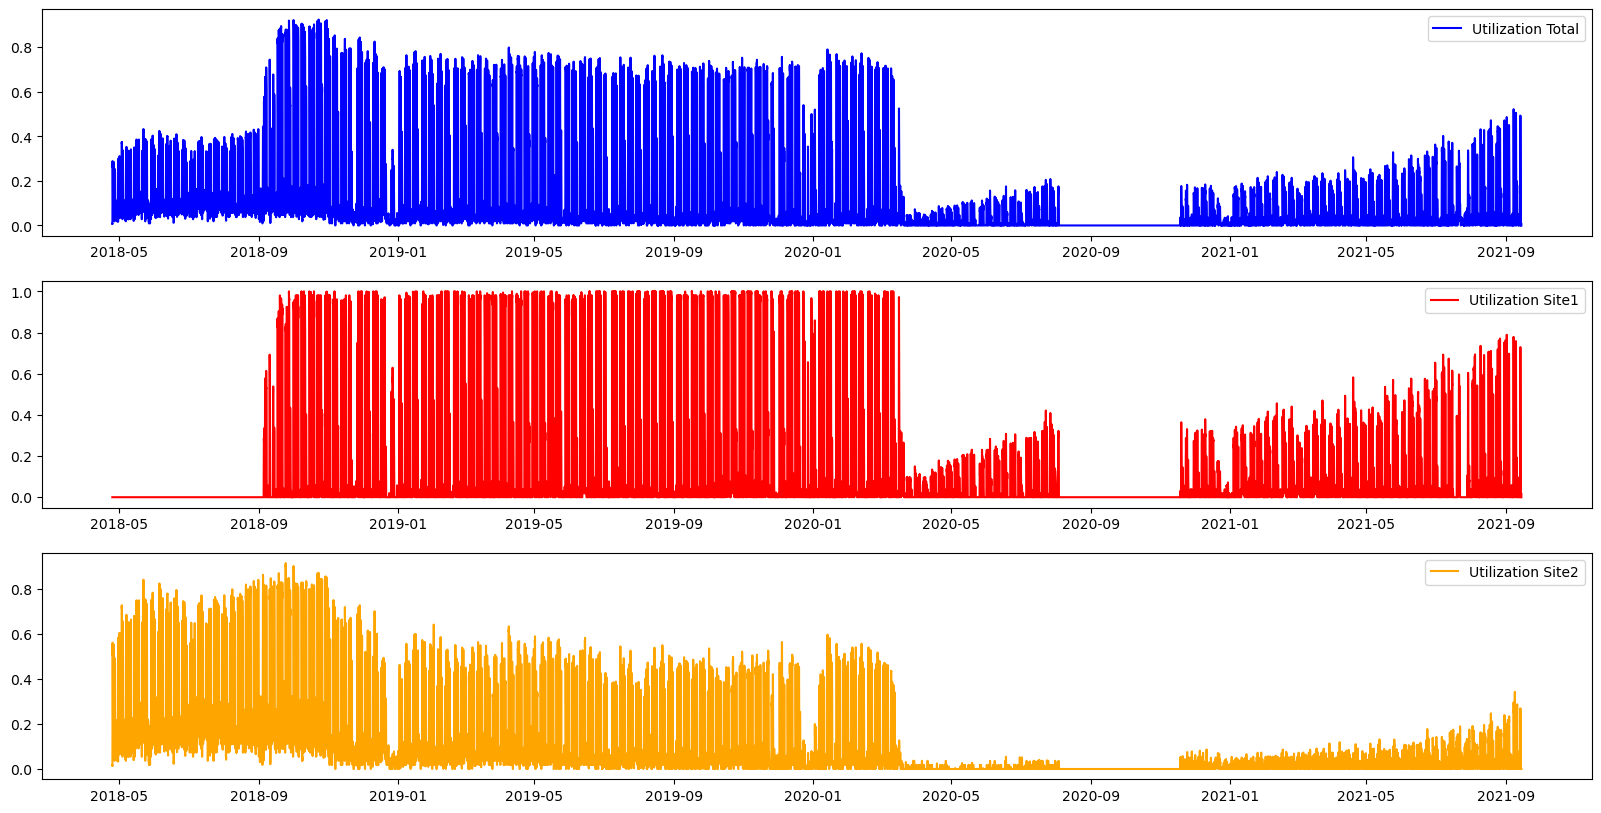

In [92]:
agg_charging_data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))
agg_charging_data['year'] = agg_charging_data.index.year

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_total'], label='Utilization Total', color='blue')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site1'], label='Utilization Site1', color='red')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site2'], label='Utilization Site2', color='orange')
plt.legend()

agg_charging_data.info(20)

If we plot the utilization over time, we can observe some intersting pattern. The Strong dip at around 03/2020 can be explained with the corona pandamic. Besides there is a time frame with no values. The objective for this task (based on the Data mining goal) is to predict the untilization of the sites for a short term after the data ends (10/2021). This is why training the models  on these extraordinary events is not feasable, which is why we are onlyusing the data frm after the data hole.

In [ ]:
agg_charging_data = agg_charging_data[agg_charging_data['year'] == 2021]
agg_charging_data['week_of_year'] = agg_charging_data['week_of_year'].astype('int32')

Define the model properties:

1. Input features: hour_of_day, day_of_week, month_of_year, year
    - Why these features: We cannot use real-time or future-dependent inputs unless they are forecasted or modeled beforehand. That is why we can obly deterministic values for our prediction.
2. Target features: utilizationRate_siteX
3. Model parameters: Coefficients (θ) for polynomial regression or weights (𝑊,𝑏) for neural network.
4. Hypothesis function: Polynomial regression: 𝑦^=ℎ𝜃(𝑋), Neural network: y^=f(W,b).
5. Objective funktion: Mean Squared Error (MSE): J(θ)=1/m*∑(y^−y)^2.

In [84]:
#different data sets to train the models
gesamt_charging_data = agg_charging_data[['utilizationRate_total', 'hour_of_day', 'day_of_week', 'month_of_year', 'kWhDelivered_total', 'activeSessions_total']]

site1_charging_data = agg_charging_data[
    ['utilizationRate_site1', 'hour_of_day', 'day_of_week', 'year', 'month_of_year', 'kWhDelivered_site1',
     'activeSessions_site1']]

site2_charging_data = agg_charging_data[
    ['utilizationRate_site2', 'hour_of_day', 'day_of_week', 'year', 'month_of_year', 'kWhDelivered_site2',
     'activeSessions_site2']]

## Neural Network

In [ ]:
# Is weekend hinzufügen
# Daten aufteilen
X = site2_charging_data[['hour_of_day', 'day_of_week', 'month_of_year', 'year']]
y = site2_charging_data['utilizationRate_site2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Daten skalieren
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modell erstellen
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)  # Für die Vorhersage eines kontinuierlichen Wertes
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Modell trainieren
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, shuffle=False)

# Vorhersagen
y_pred_nn = model.predict(X_test)


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1027 - mae: 0.1987 - val_loss: 0.0029 - val_mae: 0.0416
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0043 - mae: 0.0504 - val_loss: 0.0022 - val_mae: 0.0356
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0015 - mae: 0.0298 - val_loss: 0.0021 - val_mae: 0.0344
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.4560e-04 - mae: 0.0229 - val_loss: 0.0020 - val_mae: 0.0335
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 6.6251e-04 - mae: 0.0204 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.4963e-04 - mae: 0.0187 - val_loss: 0.0019 - val_mae: 0.0328
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.1024e-04 - mae: 0.0178 - val_loss: 0.0019 - val_mae: 0.0323
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.4685e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0317
Epoch 9/20
139/139 ━━━━━━━━━

## Polynomial regression

First, lets prepare the training and data set. To find the right degree, we train the model on a rage from 1 to 20.

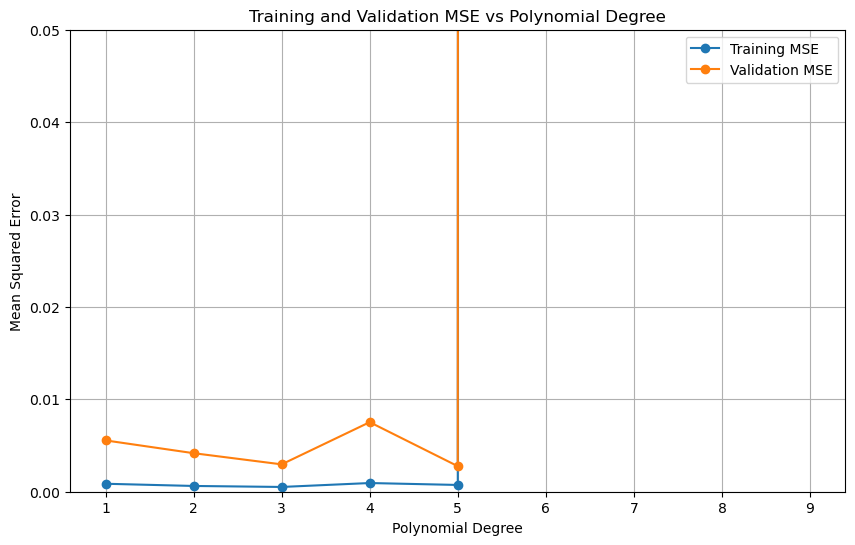

In [93]:
# Prepare data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X, y, test_size=0.1, shuffle=False)

# Initialize lists to store results
degrees = range(1, 10)  # Test polynomial degrees from 1 to 9
train_mse = []
validation_mse = []

# Loop over different polynomial degrees
for d in degrees:
    # Create a pipeline for the current degree
    pipeline = Pipeline([
        ('polynomial_features', PolynomialFeatures(degree=d)),
        ('scaler', StandardScaler()),
        ('ridge_regression', Ridge(alpha=0.0))  # First try without regularization
    ])
    
    # Fit the pipeline on training data
    pipeline.fit(X_train_poly, y_train_poly)
    
    # Calculate MSE on training data
    y_train_pred = pipeline.predict(X_train_poly)
    train_mse.append(mean_squared_error(y_train_poly, y_train_pred))
    
    # Calculate MSE on validation data
    y_test_pred = pipeline.predict(X_test_poly)
    validation_mse.append(mean_squared_error(y_test_poly, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mse, label="Training MSE", marker='o')
plt.plot(degrees, validation_mse, label="Validation MSE", marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.ylim(0, 0.05)
plt.title("Training and Validation MSE vs Polynomial Degree")
plt.legend()
plt.grid(True)
plt.show()


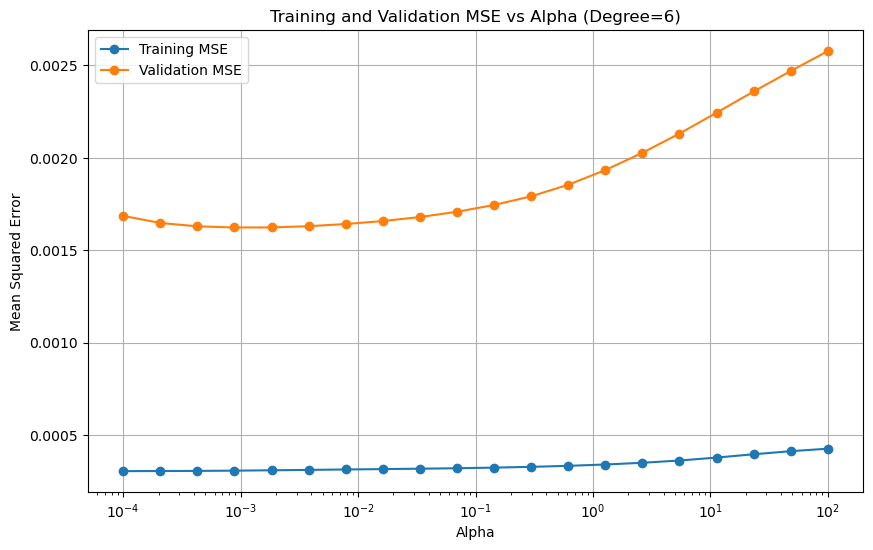

In [94]:
# Range of alpha values to test (logarithmic scale)
alphas = np.logspace(-4, 2, 20)  # From 0.0001 to 100
train_mse_alpha = []
validation_mse_alpha = []

# Loop over different alpha values
for alpha in alphas:
    # Create a pipeline with fixed degree and current alpha
    pipeline = Pipeline([
        ('polynomial_features', PolynomialFeatures(degree=6)),
        ('scaler', StandardScaler()),
        ('ridge_regression', Ridge(alpha=alpha))
    ])
    
    # Fit the pipeline on training data
    pipeline.fit(X_train_poly, y_train_poly)
    
    # Calculate MSE on training data
    y_train_pred = pipeline.predict(X_train_poly)
    train_mse_alpha.append(mean_squared_error(y_train_poly, y_train_pred))
    
    # Calculate MSE on validation data
    y_test_pred = pipeline.predict(X_test_poly)
    validation_mse_alpha.append(mean_squared_error(y_test_poly, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_mse_alpha, label="Training MSE", marker='o')
plt.plot(alphas, validation_mse_alpha, label="Validation MSE", marker='o')
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title(f"Training and Validation MSE vs Alpha (Degree={6})")
plt.legend()
plt.grid(True)
plt.show()

In [95]:
# Create a pipeline with PolynomialFeatures, scaling, and Ridge regression
D = 6
ALPHA = 0.1

pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures(degree=D)),  # Polynomial features of degree 6
    ('scaler', StandardScaler()),                          # Standardize features for regularization
    ('ridge_regression', Ridge(alpha=ALPHA))                 # Ridge regression with L2 regularization
])

# Fit the pipeline on the training data
pipeline.fit(X_train_poly, y_train_poly)

# Predict using the pipeline
y_pred_poly = pipeline.predict(X_test_poly)

# Calculate mean squared error
mse = mean_squared_error(y_test_poly, y_pred_poly)
print(f"Mean Squared Error (Polynomial Regression with Ridge Regularization): {mse}")

Mean Squared Error (Polynomial Regression with Ridge Regularization): 0.0017254710378100109


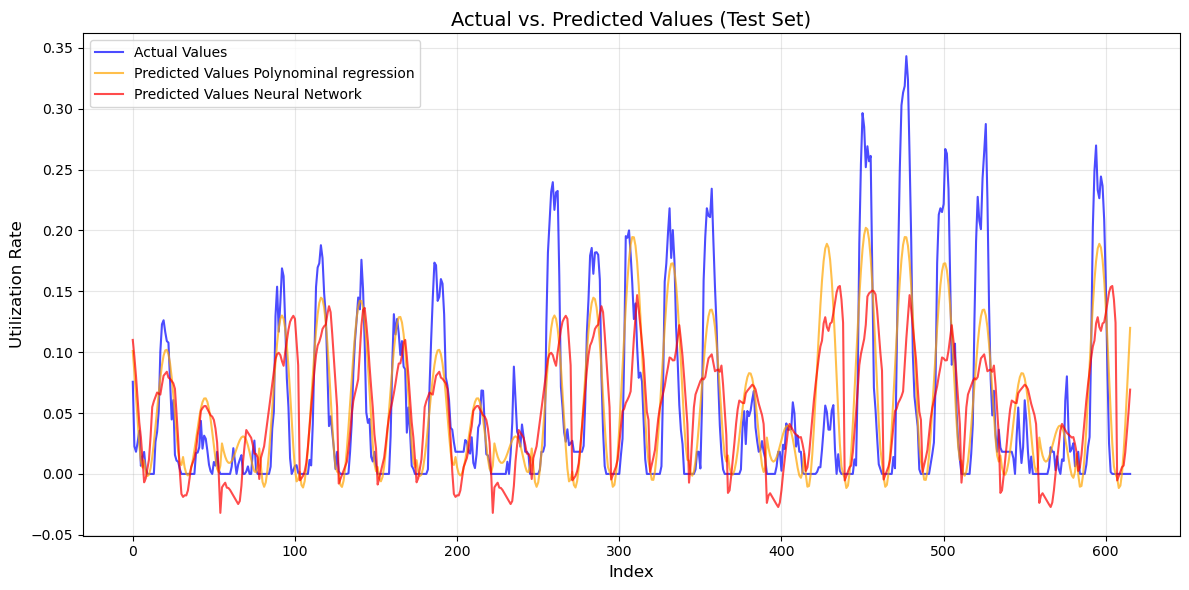

Neural Network - MSE: 0.003919384419718946, MAE: 0.04561785229330042, R²: 0.32154364051539464
Polynomial Regression - MSE: 0.0017254710378100109, MAE: 0.029050176283757456, R²: 0.7013161575019349


In [102]:
# Neuronales Netzwerk
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)


# Polynome Regression
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)


import matplotlib.pyplot as plt
import numpy as np

# Index erstellen, um die Testdaten in der Reihenfolge darzustellen
indices = np.arange(len(y_test_poly))

plt.figure(figsize=(12, 6))

# Tatsächliche Werte plotten
plt.plot(indices, y_test, label='Actual Values', color='blue', linestyle='-', alpha=0.7)

# Vorhergesagte Werte plotten
plt.plot(indices, y_pred_poly, label='Predicted Values Polynominal regression', color='orange', linestyle='-', alpha=0.7)
plt.plot(indices, y_pred_nn, label='Predicted Values Neural Network', color='red', linestyle='-', alpha=0.7)

# Titel und Achsenbeschriftungen
plt.title("Actual vs. Predicted Values (Test Set)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Utilization Rate", fontsize=12)

# Legende und Gitter
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Plot anzeigen
plt.show()
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")
print(f"Polynomial Regression - MSE: {mse_poly}, MAE: {mae_poly}, R²: {r2_poly}")


The comparison indicates a better performance of the polynominal regression, likely because of the limited complexity. Lets use the model to predict the next weeks utilization.

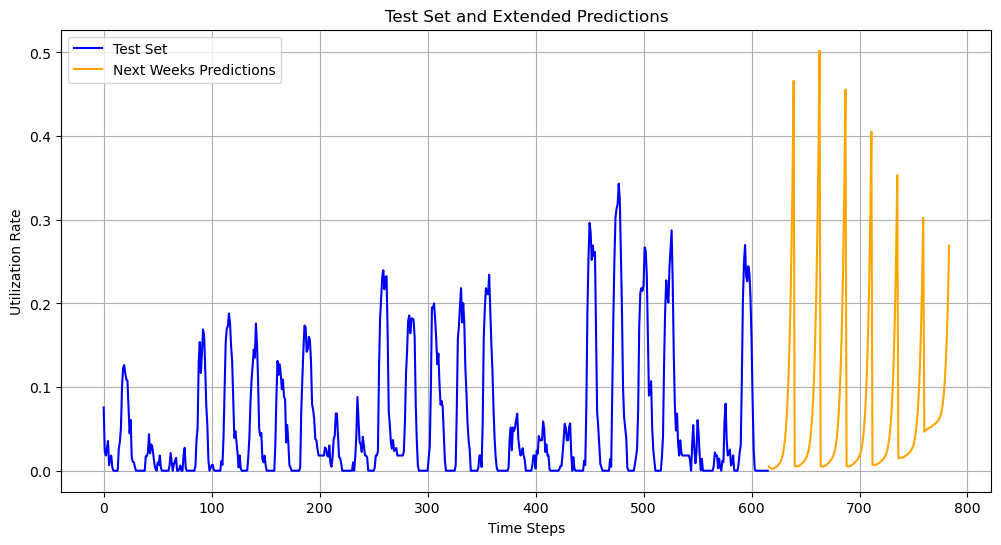

In [97]:
# Convert X_test back to a DataFrame if it's a NumPy array
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=['hour_of_day', 'day_of_week', 'month_of_year', 'year'])

# Extend the test set one month forward
def extend_test_set(X_test, n_steps=24):
    extended_test_set = pd.DataFrame()  # Initialize an empty DataFrame
    last_row = X_test.iloc[-1].copy()  # Start from the last row
    extended_rows = []
    for _ in range(n_steps):  # Simulate the next 'n_steps' rows
        last_row['hour_of_day'] += 1
        if last_row['hour_of_day'] > 24:  # Reset hour_of_day and increment day_of_week
            last_row['hour_of_day'] = 1
            last_row['day_of_week'] += 1
        if last_row['day_of_week'] > 7:  # Reset day_of_week and increment month_of_year
            last_row['day_of_week'] = 1
            last_row['month_of_year'] += 1
        if last_row['month_of_year'] > 12:  # Reset month_of_year and increment year
            last_row['month_of_year'] = 1
            last_row['year'] += 1
        extended_rows.append(last_row.copy())  # Add the new row
    
    extended_test_set = pd.concat([extended_test_set, pd.DataFrame(extended_rows)], ignore_index=True)
    return extended_test_set

# Generate extended test set
X_test_extended = extend_test_set(X_test, n_steps=168)

# Predict on the extended test set
y_extended_pred = pipeline.predict(X_test_extended)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Test Set', color='blue')
plt.plot(range(len(y_test), len(y_test) + len(y_extended_pred)), y_extended_pred, label='Next Weeks Predictions', color='orange')
plt.xlabel("Time Steps")
plt.ylabel("Utilization Rate")
plt.title("Test Set and Extended Predictions")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
model_dataset = site2_charging_data
y_output = 'utilizationRate_site2'

X = model_dataset.iloc[:,1:6]
y = model_dataset[y_output]
print(X.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6152 entries, 2021-01-01 00:00:00-08:00 to 2021-09-14 08:00:00-07:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hour_of_day           6152 non-null   int32  
 1   day_of_week           6152 non-null   int32  
 2   month_of_year         6152 non-null   int32  
 3   kWhDelivered_site2    6152 non-null   float64
 4   activeSessions_site2  6152 non-null   int64  
dtypes: float64(1), int32(3), int64(1)
memory usage: 216.3 KB
None


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Standardize features
scaler = StandardScaler()
scaler.fit(X_train)  # Fit the scaler on the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Normalize Target (y)
scaler_y = StandardScaler()  # Separate scaler for target variable

# Reshape target to fit the scaler (it expects 2D input)
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)


scaler_y.fit(y_train)           # Fit on training data
y_train_scaled = scaler_y.transform(y_train)  # Transform training data
y_test_scaled = scaler_y.transform(y_test)    # Transform test data
print(y_train)

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.05546465]
 [0.08112626]
 [0.06831313]]


In [ ]:
# Final data for the models


## 1st Model: Neural Network


In [7]:
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),  # Input layer
    BatchNormalization(),  # Normalize layer outputs
    Dropout(0.3),  # Dropout for regularization
    
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Hidden layer 1
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(16, activation="relu", kernel_regularizer=l2(0.001)),  # Hidden layer 2
    Dropout(0.2),
    
    Dense(1, activation="linear")  # Output layer for regression
])

In [8]:
# Compiling the ANN
model.compile(loss='mse', optimizer="adam", metrics=["mae", "mse"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.9783 - mae: 0.6834 - mse: 0.9063 - val_loss: 0.0858 - val_mae: 0.1015 - val_mse: 0.0165
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.3690 - mae: 0.3993 - mse: 0.3002 - val_loss: 0.0992 - val_mae: 0.1301 - val_mse: 0.0320
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2307 - mae: 0.2954 - mse: 0.1640 - val_loss: 0.0738 - val_mae: 0.0719 - val_mse: 0.0084
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1642 - mae: 0.2193 - mse: 0.0992 - val_loss: 0.0702 - val_mae: 0.0625 - val_mse: 0.0064
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1252 - mae: 0.1790 - mse: 0.0618 - val_loss: 0.0680 - val_mae: 0.0587 - val_mse: 0.0057
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1086 - mae: 0.1467 - mse: 0.0467 - val_loss: 0.0648 - val_mae: 0.0465 - val_mse: 0.0040
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0926 - mae: 0.1254 - mse: 0.032

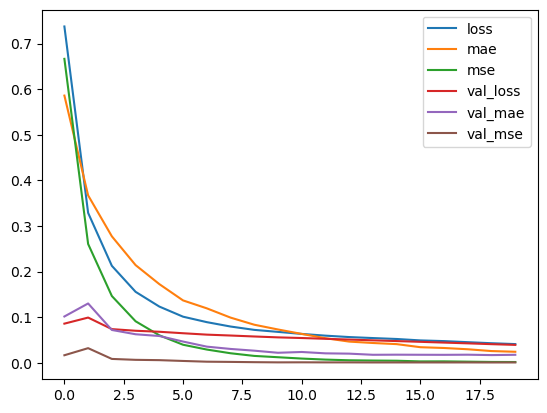

In [9]:
def train_and_evaluate(model, visualize=False):
    history = model.fit(X_train, y_train, batch_size = 20, epochs = 20, validation_split=0.4)
    if visualize:
        pd.DataFrame(history.history).plot()

train_and_evaluate(model, visualize=True)